In [1]:
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

%load_ext autoreload
%autoreload 2

In [2]:
PATH_EXPERIMENT = Path("/beegfs/ws/0/s4610340-sleep_states/kaggle-detect_sleep_states/outputs/train/CNNSpectrogram-UNet1DDecoder/2023-11-23_16-08-35/single")
PATH_EXPERIMENT

PosixPath('/beegfs/ws/0/s4610340-sleep_states/kaggle-detect_sleep_states/outputs/train/CNNSpectrogram-UNet1DDecoder/2023-11-23_16-08-35/single')

In [34]:
predictions = np.load(PATH_EXPERIMENT / "preds.npy")
predictions.shape

(4814, 5760, 2)

In [35]:
labels = np.load(PATH_EXPERIMENT / "labels.npy")
labels.shape

(4814, 5760, 2)

In [36]:
keys = np.load(PATH_EXPERIMENT / "keys.npy")
keys.shape

(4814,)

In [37]:
import detect_sleep_states.config
import detect_sleep_states.data_module
import hydra


with hydra.initialize_config_dir(version_base=None, config_dir=str(PATH_EXPERIMENT / ".hydra")):
    cfg: detect_sleep_states.config.TrainConfig = hydra.compose(config_name="config")

features = detect_sleep_states.data_module.load_chunk_features(
    duration=cfg.duration,
    feature_names=cfg.features,
    series_ids=cfg.split.valid_series_ids,
    processed_dir=Path(cfg.dir.processed_dir),
    phase="train"
)

features

{'03d92c9f6f8a_0000000': array([[ 1.34292948e+00,  3.82847756e-01, -8.66025404e-01,
         -5.00000000e-01],
        [ 1.07496786e+00,  3.32763731e-01, -8.66025404e-01,
         -5.00000000e-01],
        [ 1.29597807e+00,  1.35310185e+00, -8.66025404e-01,
         -5.00000000e-01],
        ...,
        [ 4.99049544e-01, -3.94926786e-01, -2.58819045e-01,
          9.65925826e-01],
        [ 4.13803458e-01, -3.94926786e-01, -2.58819045e-01,
          9.65925826e-01],
        [ 6.49629452e-04, -3.85106415e-01, -2.58819045e-01,
          9.65925826e-01]]),
 '03d92c9f6f8a_0000001': array([[-0.04361605, -0.38805252,  0.        ,  1.        ],
        [ 0.21105517, -0.4057292 ,  0.        ,  1.        ],
        [-0.0559127 , -0.39885494,  0.        ,  1.        ],
        ...,
        [ 0.57469869, -0.4057292 ,  0.96592583, -0.25881905],
        [ 0.57469869, -0.4057292 ,  0.96592583, -0.25881905],
        [ 0.57469869, -0.4057292 ,  0.96592583, -0.25881905]]),
 '03d92c9f6f8a_0000002': arr

In [38]:
features["03d92c9f6f8a_0000000"].shape

(5760, 4)

In [8]:
cfg.features

['anglez', 'enmo', 'hour_sin', 'hour_cos']

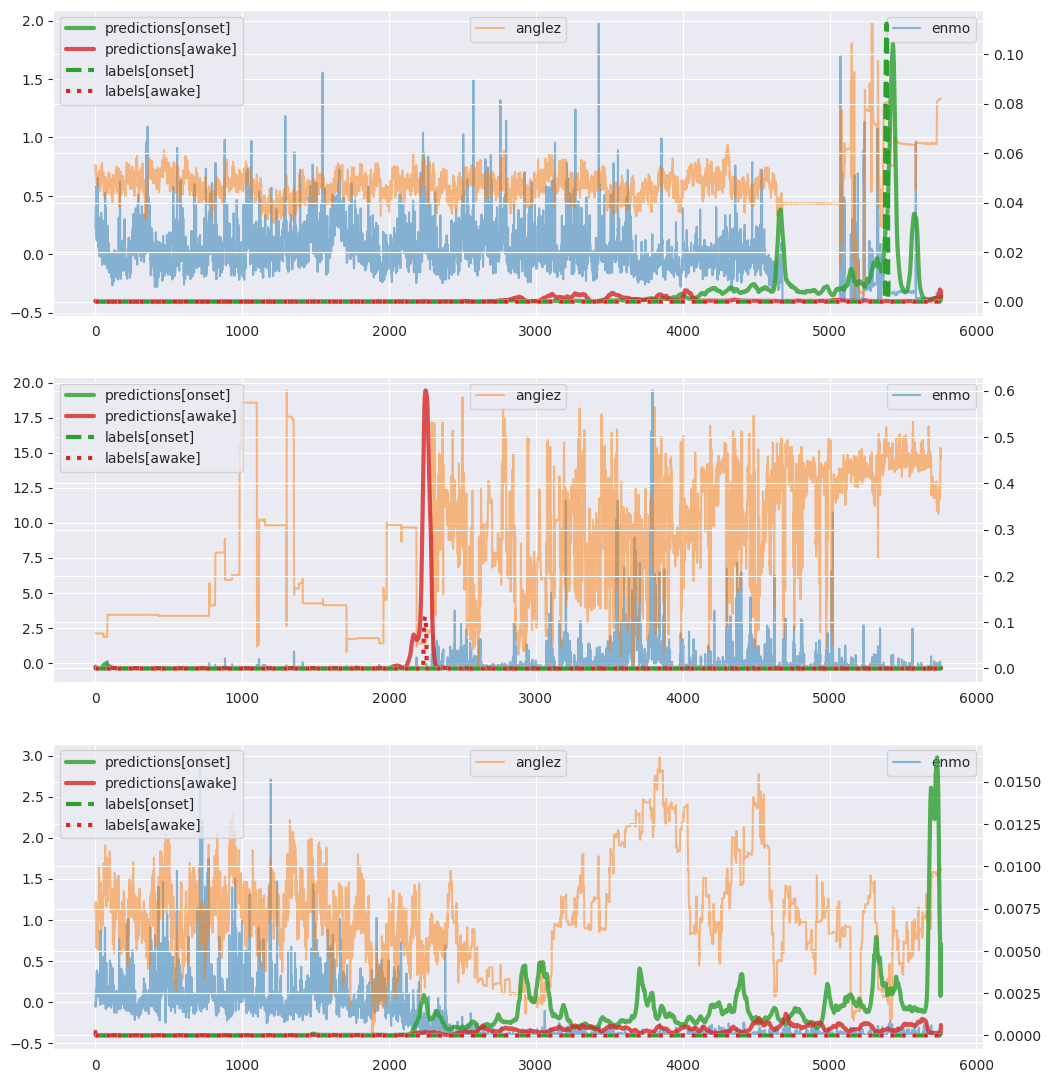

In [12]:
import matplotlib.patheffects as pe
import detect_sleep_states.utils.common
sample_size: int = 3

fig: plt.Figure
fig, axs = plt.subplots(nrows=sample_size, ncols=1, figsize=(12, sample_size*4.5))

ax: plt.Axes

colors = sns.color_palette()

keys: np.ndarray


for ax, key_i in zip(axs, np.random.choice(len(keys), size=sample_size, replace=False)):
    chunk_features = features[keys[key_i]]
    
    anglez = chunk_features[:, 0]
    enmo = chunk_features[:, 1]
    
    ax.plot(enmo, label="enmo", color=colors[0], alpha=0.5)
    
    #ax.set_xticklabels([i * 5 / 3600 for i in range(len(enmo))])
    
    ax_anglez: plt.Axes = ax.twinx()
    ax_anglez.plot(anglez, label="anglez", color=colors[1], alpha=0.5)
    ax_anglez.set_yticks([])
    
    ax_prob: plt.Axes = ax.twinx()
    ax_prob.plot(
        predictions[key_i, :, 0], 
        label="predictions[onset]", 
        color=colors[2], 
        linewidth=3, 
        alpha=0.8
    )
    ax_prob.plot(predictions[key_i, :, 1], label="predictions[awake]", color=colors[3], linewidth=3, alpha=0.8)
    
    chunk_labels_smoothed = detect_sleep_states.utils.common.gaussian_label(
        labels[key_i, :, :],
        sigma=10,
        radius=10
    )
    ax_prob.plot(
        chunk_labels_smoothed[:, 0], 
        label="labels[onset]", 
        color=colors[2], 
        linestyle="--", 
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()]
    )
    ax_prob.plot(
        chunk_labels_smoothed[:, 1], 
        label="labels[awake]", 
        color=colors[3], 
        linestyle=":", 
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()]
    )
    
    ax_prob.legend(loc="upper left")
    ax_anglez.legend(loc="upper center")
    ax.legend(loc="upper right")
    
    

In [50]:
import pandas as pd
df_keys = pd.DataFrame(np.char.split(keys, "_").tolist(), columns=["series_id", "chunk_id"]).reset_index(names=["index"])

features_c = []
predictions_c = []
labels_c = []

for series_id, df_g in df_keys.groupby("series_id"):
    features_g = np.hstack([features[keys[i]] for i in df_g["index"]])
    predictions_g = np.hstack(predictions[df_g["index"]])
    labels_g = np.hstack(labels[df_g["index"]])
    features_c.append(features_g)
    predictions_c.append(predictions_g)
    labels_c.append(labels_c)
    break

detect_sleep_states.plot.plot_predictions.plot_predictions_chunk(
    predictions=np.array(predictions_c[0]),
    features=np.array(features_c[0]),
    labels=np.array(labels_c[0]),
    cfg=cfg
)

    

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

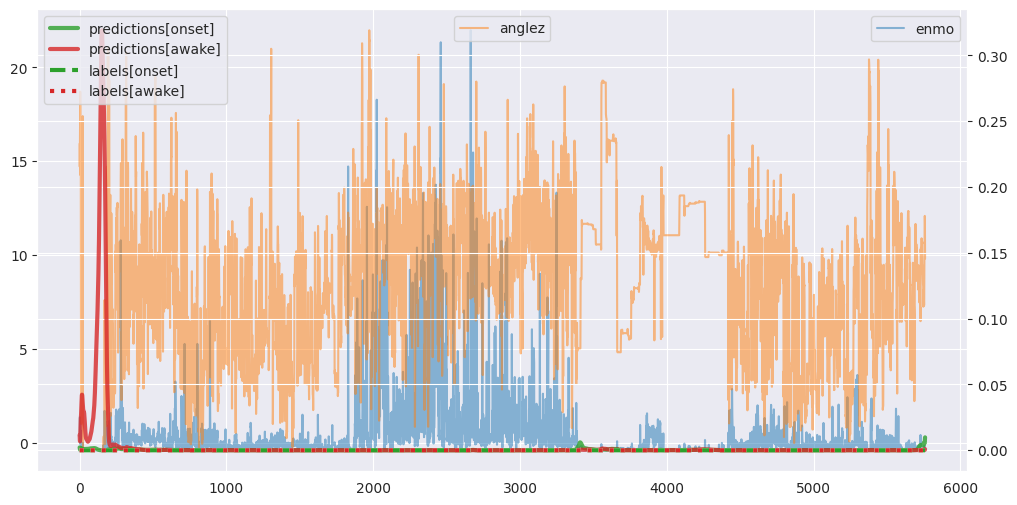

In [11]:
import detect_sleep_states.plot.plot_predictions

detect_sleep_states.plot.plot_predictions.plot_predictions_chunk(
    predictions=predictions[0],
    features=features[keys[0]],
    labels=labels[0],
    cfg=cfg
)

In [ ]:
smoothed_labels.shape

In [16]:
cfg.dataset

{'name': 'seg', 'batch_size': '${batch_size}', 'num_workers': '${num_workers}', 'offset': 10, 'sigma': 10, 'bg_sampling_rate': 0.5}

/tmp/ipykernel_94079/3975193823.py:23: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(smoothed_labels_1[:, i]*2 / smoothed_labels_1[:, i].max(), label="new")


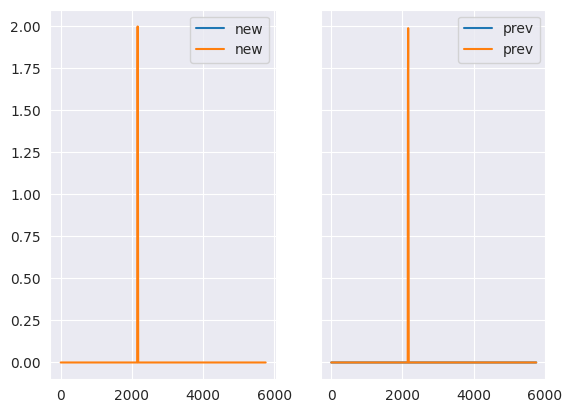

In [41]:
# ref: https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/discussion/360236#2004730
def gaussian_kernel(length: int, sigma: int = 3) -> np.ndarray:
    x = np.ogrid[-length : length + 1]
    h = np.exp(-(x**2) / (2 * sigma * sigma))  # type: ignore
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_label(label: np.ndarray, offset: int, sigma: int) -> np.ndarray:
    num_events = label.shape[1]
    for i in range(num_events):
        label[:, i] = np.convolve(label[:, i], gaussian_kernel(offset, sigma), mode="same")

    return label

from scipy.ndimage import gaussian_filter1d
example_labels = labels[14].copy()
smoothed_labels_1 = gaussian_filter1d(example_labels, sigma=10, radius=10, mode="constant", cval=0.0, axis=0)
smoothed_labels_2 = gaussian_label(example_labels, sigma=10, offset=10)

fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True)

for i in range(2):
    axs[0].plot(smoothed_labels_1[:, i]*2 / smoothed_labels_1[:, i].max(), label="new")
    
for i in range(2):
    axs[1].plot(smoothed_labels_2[:, i], label="prev")

axs[0].legend()
axs[1].legend()

In [30]:
smoothed_labels_2.max()

0.0